# Estimate of supercooling in the model

In [15]:
# get environment variables
import os
import sys
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

sys.path.append(os.environ.get('srcdir'))

In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as ocm
import gsw
from features.calc_z import calc_z

In [17]:
# load annual mean potential temperature and practical salinity of roms surface layer
his_path = os.path.join(os.environ.get("rawdir"),'waom10_hot','ocean_his.nc')
sl = xr.open_dataset(his_path,decode_times=False).isel(s_rho=-1,ocean_time=9)
grd_path = os.path.join(os.environ.get("prodir"),'waom10_grd.nc')
grd = xr.open_dataset(grd_path)

In [22]:
# load annual mean potential temperature and practical salinity of roms surface layer
his_path = os.path.join(os.environ.get("rawdir"),'waom10_hot','ocean_his.nc')
sl_summer = xr.open_dataset(his_path,decode_times=False).isel(s_rho=-1,ocean_time=10)

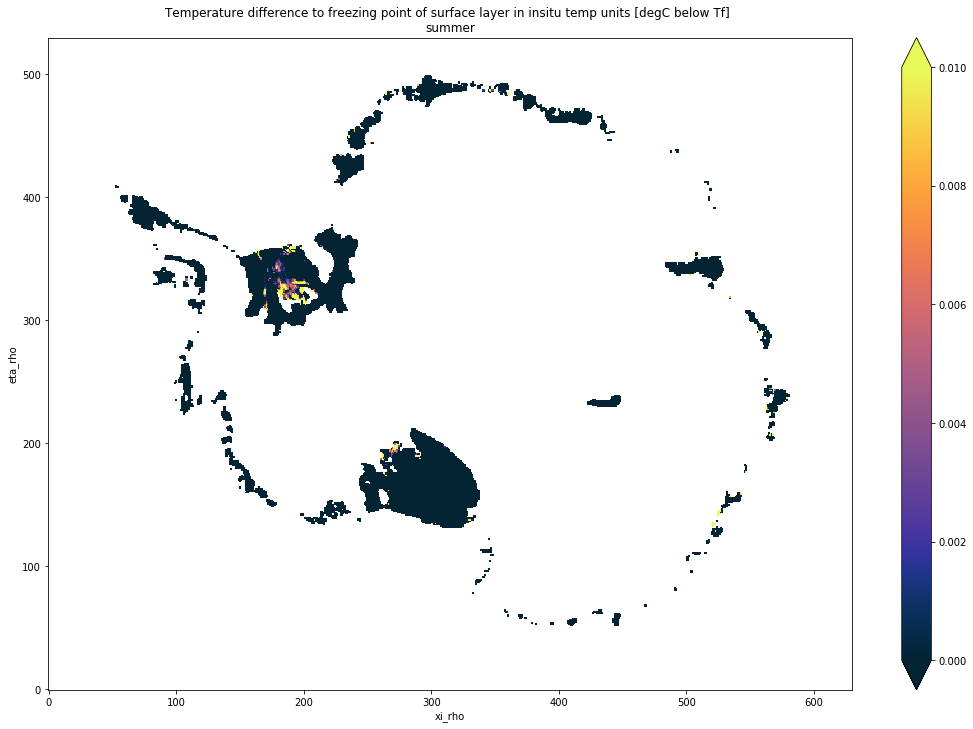

In [23]:
plot_sc(sl_summer,grd,'summer')

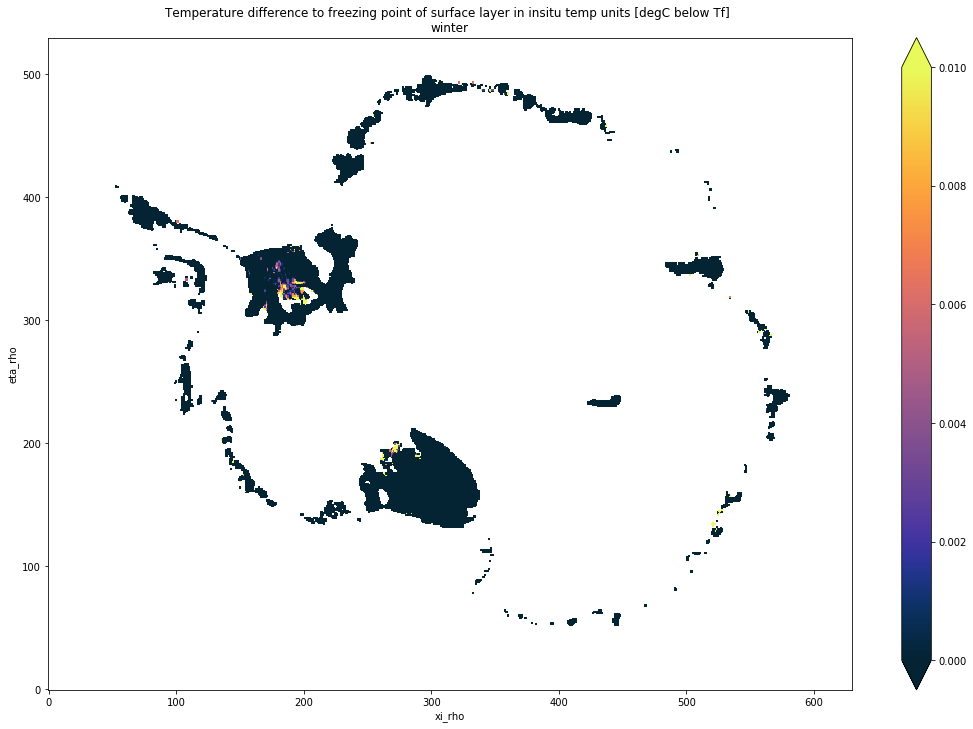

In [24]:
plot_sc(sl,grd,'winter')

## check up with refreezing in the model

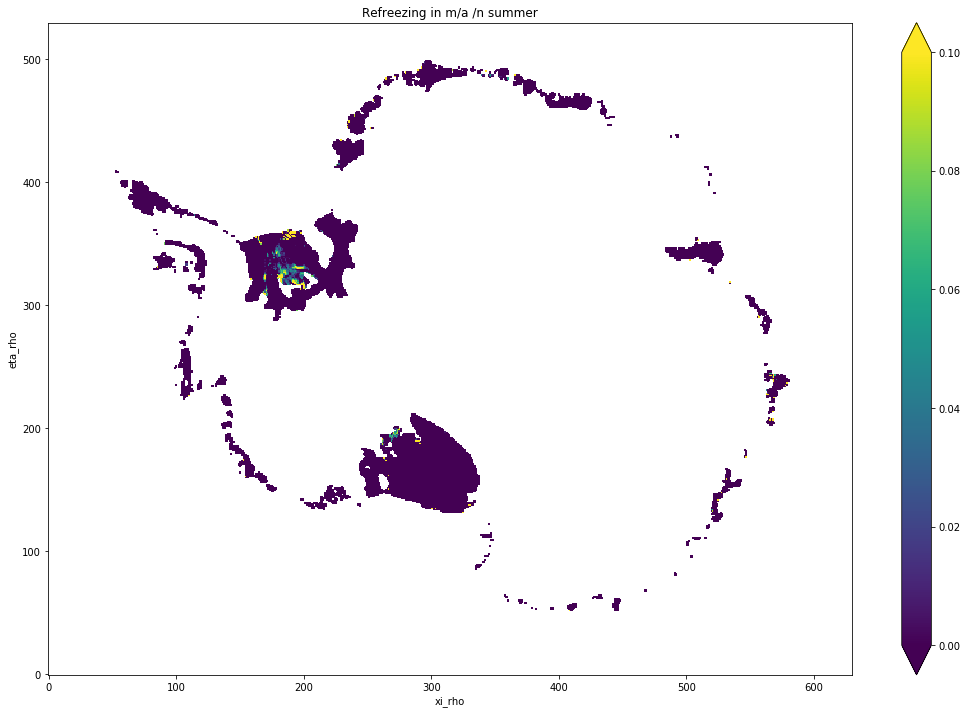

In [27]:
s2a = 3600*24*365
plt.close()
(sl_summer.m*-s2a).where((grd.zice<0)&(grd.mask_rho==1)).plot(vmin=0,vmax=0.1,size=12)
plt.title('Refreezing in m/a /n summer')
plt.show()

In [28]:
path = os.path.join(os.environ.get('rawdir'),'waom4_hot','ocean_his_0001.nc')
hot_hr = xr.open_dataset(path)
s2a = 3600*24*365
hot_hr['m'] = hot_hr.m*s2a

path = os.path.join(os.environ.get('rawdir'),'gdata','waom4_frc','waom4_grd.nc')
grd_hr = xr.open_dataset(path)

In [29]:
plot_sc(hot_hr,grd_hr,'4km winter')

ValueError: dimensions ('eta_rho', 'xi_rho') must have the same length as the number of data dimensions, ndim=4

In [ ]:
def plot_sc(sl,grd,case):
    # first calculate depth of mix surface layer (z[30])
    z,s,C = calc_z(grd.h.values,grd.zice.values,sl.theta_s.values,sl.theta_b.values,sl.hc.values,31)

    # then calculate freezing point as insitu temp unit
    a = -0.057
    b = 0.0939
    c = 7.61e-4
    Tf = sl.salt * a + b + c*z[30]
    
    # convert Tf from insitu to potential temp unit
    p = gsw.conversions.p_from_z(z[30],grd.lat_rho)
    SA = gsw.conversions.SA_from_SP(sl.salt,p,grd.lon_rho,grd.lat_rho)
    Tfp = gsw.conversions.pt_from_t(SA,sl.temp,p,0.0)
    
    #convert potential temperture  of surface layer to insitu temperature 
    CT = gsw.conversions.CT_from_pt(SA,sl.temp)
    sl['t'] = xr.DataArray(gsw.conversions.t_from_CT(SA,CT,p),dims=['eta_rho','xi_rho'])
    
    # calculate and plot difference to freezing point in insitu temp units
    plt.close()
    (Tf-sl.t).where(grd.zice<0).plot(vmin=0,vmax=0.01,size=12,cmap=ocm.thermal)
    plt.title('Temperature difference to freezing point of surface layer in insitu temp units [degC below Tf] \n'+case)
    plt.show()

## option one: converting freezing point of surface layer to potential temp units

In [ ]:
# first calculate depth of mix surface layer (z[30])
z,s,C = calc_z(grd.h.values,grd.zice.values,sl.theta_s.values,sl.theta_b.values,sl.hc.values,31)

# then calculate freezing point as insitu temp unit
a = -0.057
b = 0.0939
c = 7.61e-4
Tf = sl.salt * a + b + c*z[30]

In [ ]:
# convert Tf from insitu to potential temp unit
p = gsw.conversions.p_from_z(z[30],grd.lat_rho)
SA = gsw.conversions.SA_from_SP(sl.salt,p,grd.lon_rho,grd.lat_rho)
Tfp = gsw.conversions.pt_from_t(SA,sl.temp,p,0.0)

In [ ]:
# few checkup plots
plt.close()
plt.title('surface layer depth in m')
plt.pcolormesh(z[30])
plt.colorbar()
plt.show()
plt.title('surface layer pressure in dbar')
plt.pcolormesh(p)
plt.colorbar()
plt.show()
plt.title('surface layer insitu temp in degC')
plt.pcolormesh(Tf)
plt.colorbar()
plt.show()
plt.title('surface layer potential temp in degC')
plt.pcolormesh(Tfp)
plt.colorbar()
plt.show()

In [ ]:
# calculate and plot difference to freezing point in potential temp units
plt.close()
(Tfp-sl.temp).where(grd.zice<0).plot(size=12,cmap=ocm.thermal,vmin=0,vmax=0.01)
plt.title('Temperature difference to freezing point in surface layer in pot temp units [degC below Tf]')
plt.show()

## option two: converting temperature of surface layer to insitu temp units

In [ ]:
#convert potential temperture  of surface layer to insitu temperature 
CT = gsw.conversions.CT_from_pt(SA,sl.temp)
sl['t'] = xr.DataArray(gsw.conversions.t_from_CT(SA,CT,p),dims=['eta_rho','xi_rho'])

In [ ]:
# calculate and plot difference to freezing point in insitu temp units
plt.close()
(Tf-sl.t).where(grd.zice<0).plot(vmin=0,vmax=0.01,size=12,cmap=ocm.thermal)
plt.title('Temperature difference to freezing point of surface layer in insitu temp units [degC below Tf]')
plt.show()